## Data acquisition

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
# import seaborn as sns
from matplotlib.gridspec import GridSpec
from lmfit.models import GaussianModel
from scipy.signal import find_peaks

import drop_detection_tools as ddt


from tqdm import tqdm
%matplotlib inline

<Figure size 432x288 with 0 Axes>

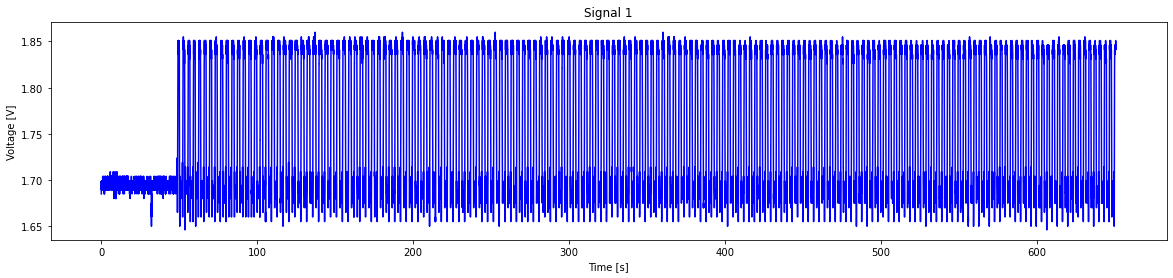

<Figure size 432x288 with 0 Axes>

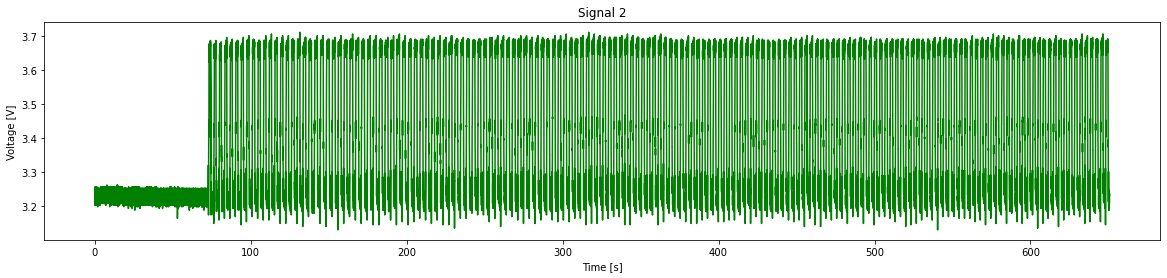

In [2]:
#************************************
folder   = 'T-data/2-12/'
filename = 'B-ol5-aq5-pause10.csv'
name = '2-12_B-ol5-aq5'
#************************************

raw = True


sig1, sig2, t = ddt.read_LV(folder, filename)

### Resample data

Text(0.5, 1.0, 'Signal 2')

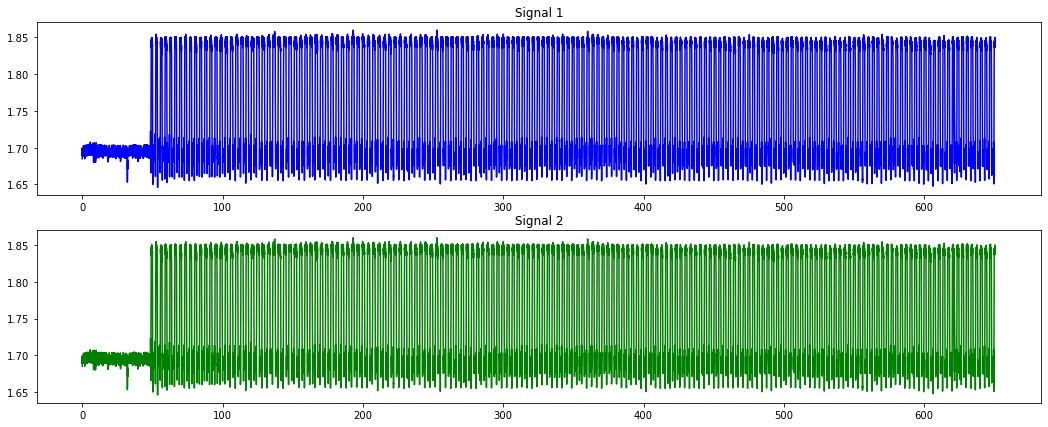

In [3]:
dt = 0.01 # sampling time

if raw:
    sig1, new_t = ddt.resample(sig1, t, dt=dt)
    sig2, _ = ddt.resample(sig2, t, dt=dt)
    t = new_t
    raw = False
else:
    print('data already resampled')


fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(18,7))

axs[0].plot(t, sig1, color='blue')
axs[0].set_title('Signal 1')

axs[1].plot(t, sig1, color='green')
axs[1].set_title('Signal 2')


## Fourier transformation


In [5]:
min_freq  = 1       # lower cut-off frequency
max_freq  = 17500   # higher cut-off frequency

### Signal 1 

/home/alessandro/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/alessandro/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


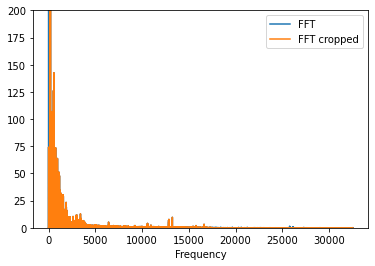

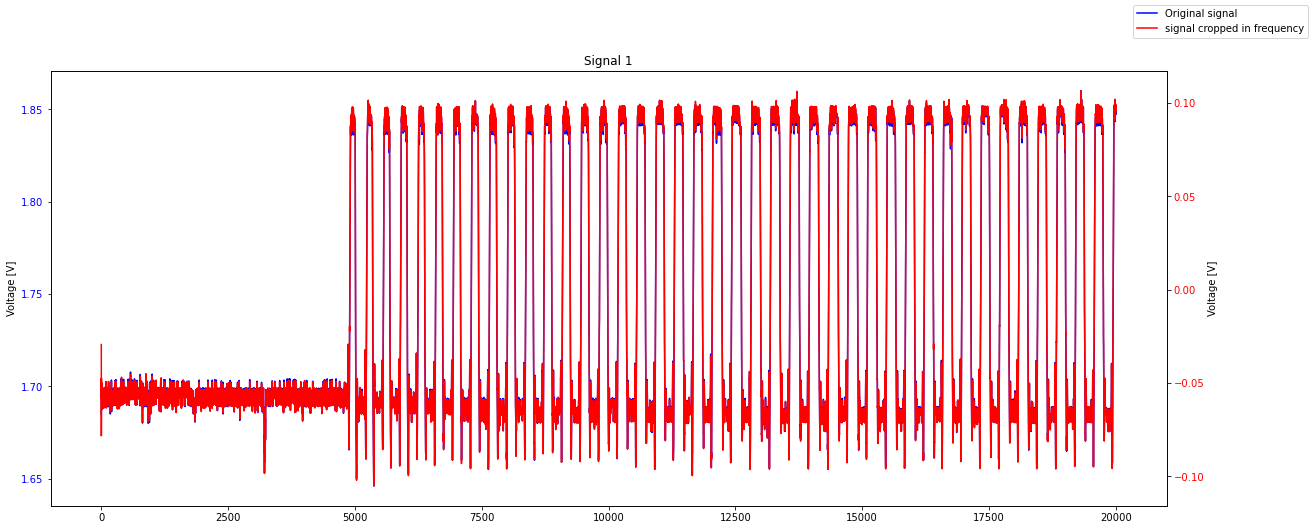

In [6]:
# FFT transform filtering
sig1_high = ddt.FFT_cropping(sig1, min_freq, max_freq)

x_min = 0       # signal plot x min.
x_max = 20000   # signal plot x max.
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20,8))

# Signal plot
color = 'blue'
ax1.set_title('Signal 1')
ax1.set_xlabel('')
ax1.set_ylabel('Voltage [V]')
ax1.plot(sig1[x_min:x_max], color = color, label='Original signal')
ax1.tick_params(axis = 'y', labelcolor = color)

# Filtered signal plot
color = 'red'
ax2 = ax1.twinx()   
ax2.set_xlabel('')
ax2.set_ylabel('Voltage [V]')                     
ax2.plot(sig1_high[x_min:x_max], color = color, label='signal cropped in frequency')
ax2.tick_params(axis = 'y', labelcolor = color)
fig.legend()


### Signal 2 

/home/alessandro/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/alessandro/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


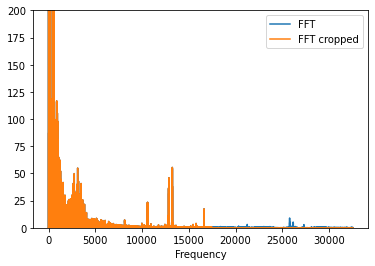

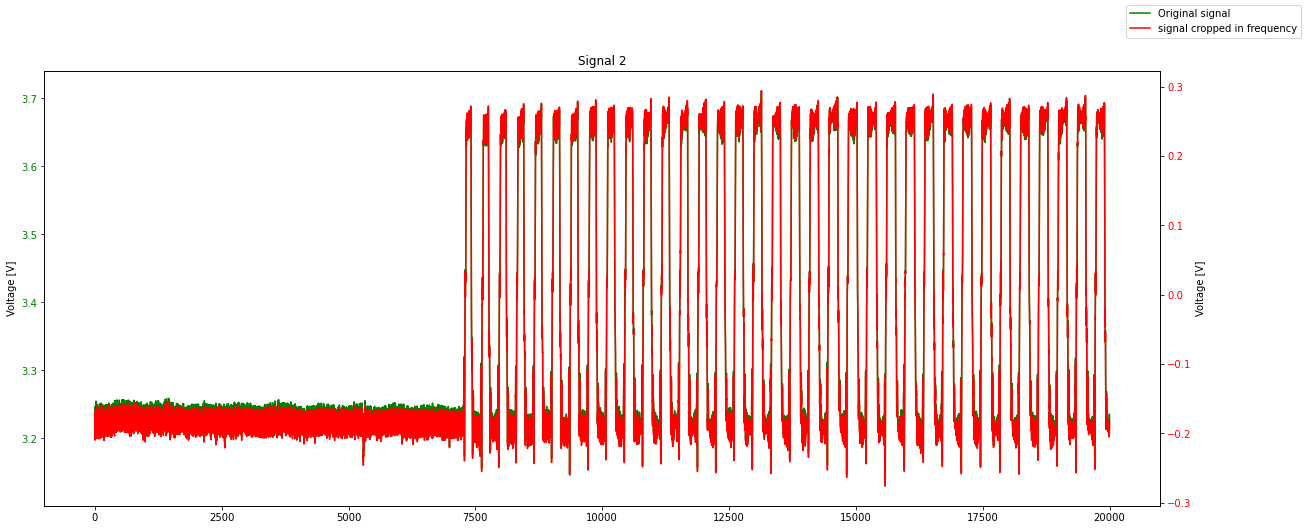

In [7]:
# FFT transform filtering
sig2_high = ddt.FFT_cropping(sig2, min_freq, max_freq)

x_min = 0    # Plot x min.
x_max = 20000  # Plot x max. 
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20,8))

# Signal plot
color = 'green'
ax1.set_title('Signal 2')
ax1.set_xlabel('')
ax1.set_ylabel('Voltage [V]')
ax1.plot(sig2[x_min:x_max], color = color, label='Original signal')
ax1.tick_params(axis = 'y', labelcolor= color)

# Filtered signal plot
color = 'red'
ax2 = ax1.twinx()                                 
ax2.set_ylabel('Voltage [V]')                     
ax2.plot(sig2_high[x_min:x_max], color = color, label='signal cropped in frequency')
ax2.tick_params(axis = 'y', labelcolor = color)
fig.legend()

### Normalize signals

In [8]:
def normalize(sig):
    c = np.mean(np.abs(sig))
    return sig/c

In [9]:
sig1_high = normalize(sig1_high)
sig2_high = normalize(sig2_high)

<IPython.core.display.Javascript object>


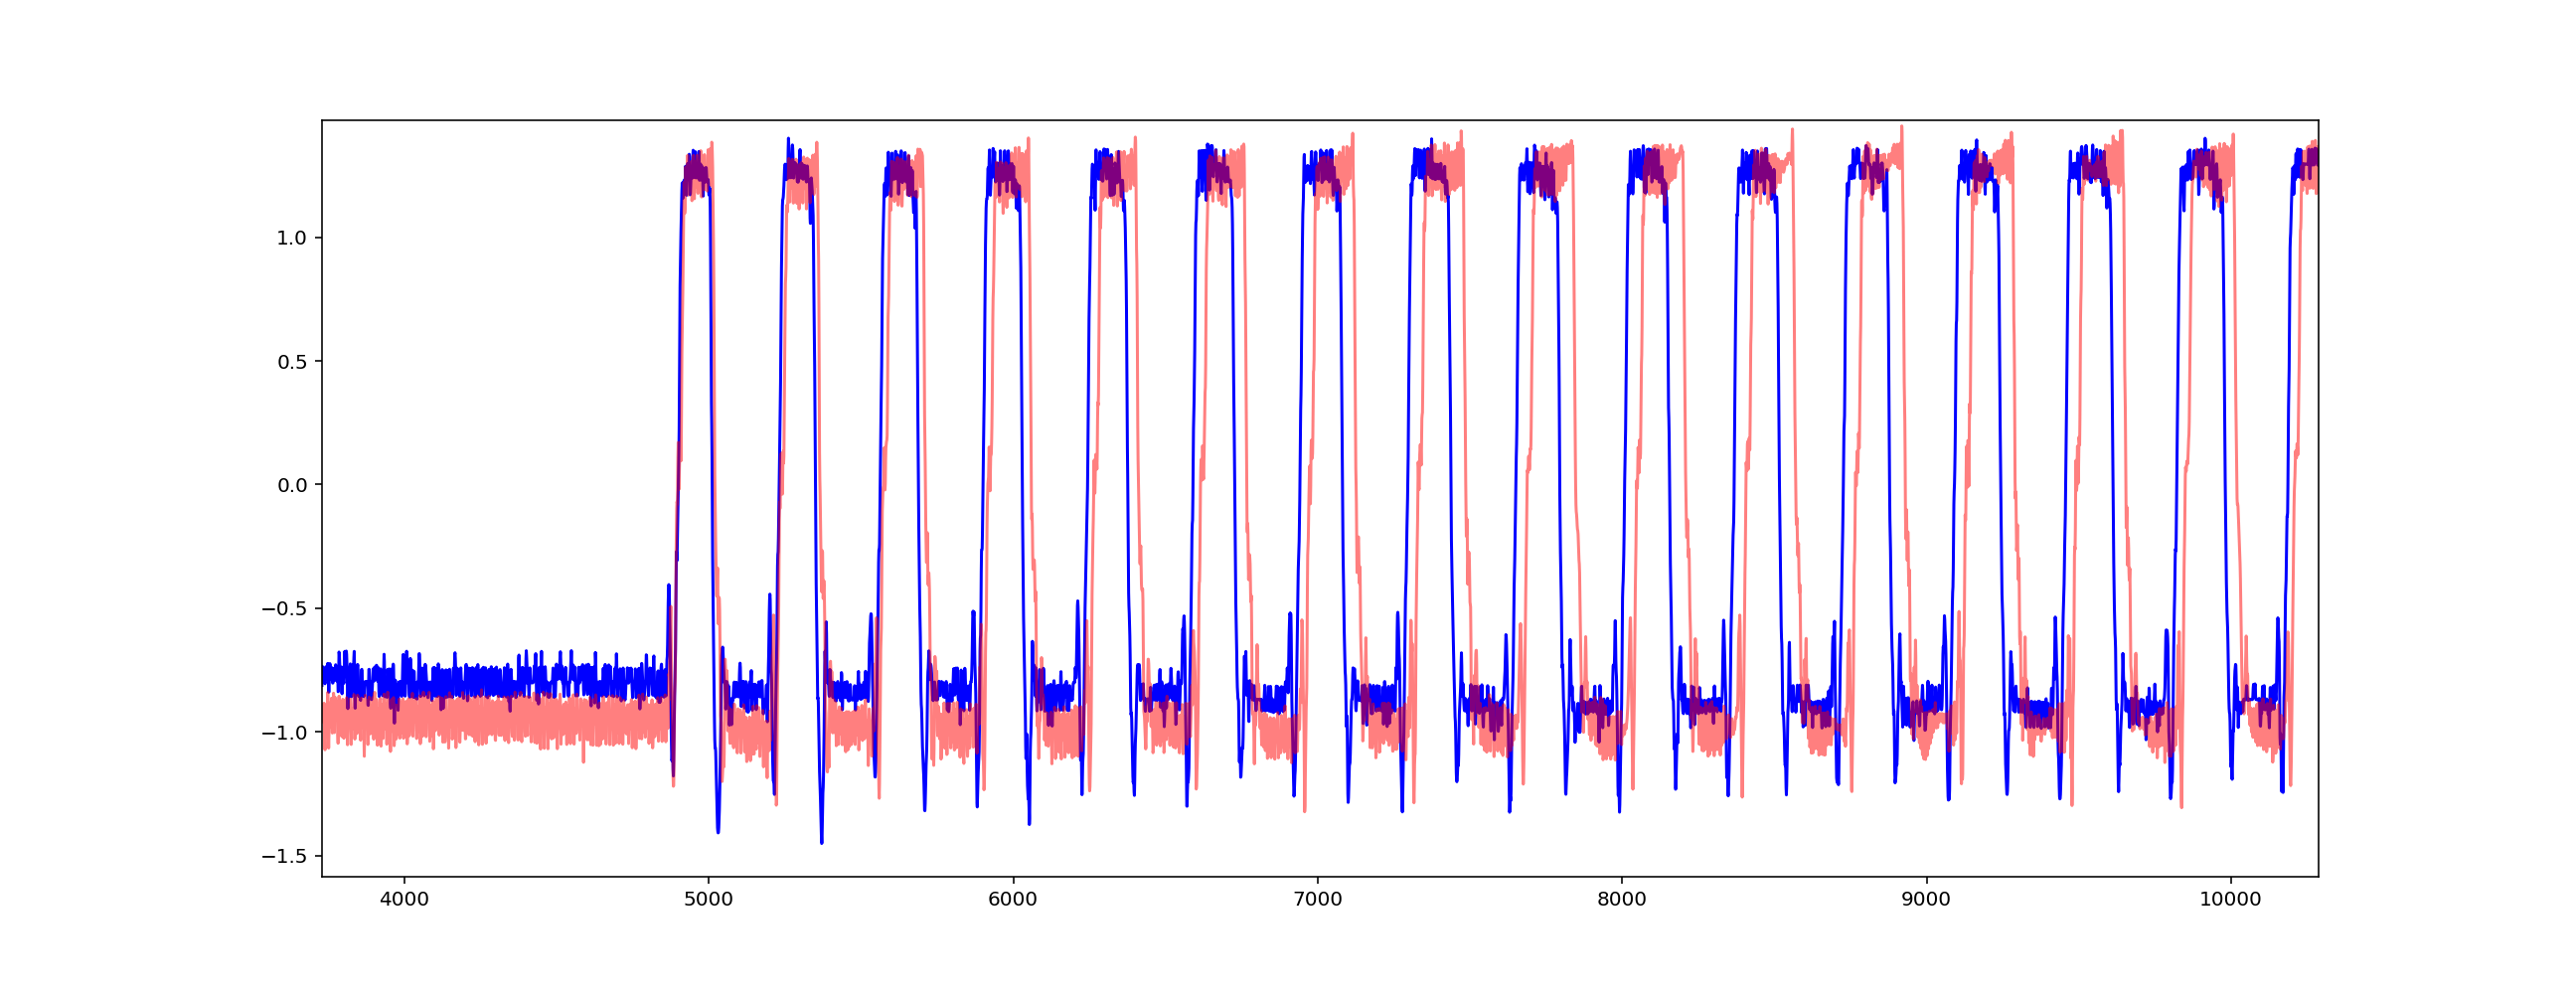

In [33]:
%matplotlib notebook
%matplotlib notebook
plt.figure(figsize=(18,7))
plt.plot(sig1_high, color='blue')
plt.plot(sig2_high[2400:], color='red', alpha=0.5)

## Thresholds computing

### Customizable

In [ ]:
def thr_searcher(Data, nbins, color):
    
    # Histogram definition
    freq,bins,p = plt.hist(Data, nbins, color=color)
    x = 0.5 *(bins[:-1] + bins[1:])
    plt.clf() # Clear figure
    
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    #Cicle changing center1 position if condition (center1+2*sigma1 < center2-2*sigma2) is not fulfilled
    for i in range(1,6):    

        # Gaussian 1
        gauss1 = GaussianModel(prefix='g1_')
        pars   = gauss1.make_params(center=x[0]+i*(x[-1]-x[0])/10, sigma=(x[-1]-x[0])/15 , amplitude=max(freq)/20)
        
        # Gaussian 2
        gauss2 = GaussianModel(prefix='g2_')
        pars.update(gauss2.make_params())

        # Gaussian 1 parameters
        pars['g1_center'].set(max = x[0]+(x[-1]-x[0])*0.7, min=min(x))
        pars['g1_sigma'].set(max=(x[-1]-x[0])/10, min=(x[-1]-x[0])/30)
        #pars['g1_amplitude'].set(value=max(freq)/20,min=10)

        # Gaussian 2 parameters
        pars['g2_center'].set(value=x[-1]*0.98)
        pars['g2_sigma'].set(value=(x[-1]-x[0])/15)
        pars['g2_amplitude'].set(value=max(freq)/20, min=10)

        mod  = gauss1 + gauss2
        init = mod.eval(pars, x=x)
        out  = mod.fit(freq, pars, x=x)

        # Plot histo
        axes[0].hist(Data, nbins, color=color)
        axes[0].plot(x, out.init_fit, 'k--', label='initial fit')
        axes[0].plot(x, out.best_fit, 'r-', label='best fit')
        axes[0].legend(loc='best')
        axes[0].set_title("Signal histogram")
        axes[0].set_xlabel("Voltage [V]")
        axes[0].set_ylabel("Number of events") 

        # Searching the best fit
        center2 = out.best_values.get('g2_center')
        sigma2  = out.best_values.get('g2_sigma')
        center1 = out.best_values.get('g1_center')
        sigma1  = out.best_values.get('g1_sigma')

        if center1+2*sigma1 < center2-2*sigma2:
            max_freq1 = max(freq[x<center1+sigma1])
            x_max1    = x[np.argmax(freq[x<center1+2*sigma1])]
            max_freq2 = max(freq[x>center2-sigma2])
            a         = x > center2-sigma2
            freq2     = np.zeros(len(freq))
            for i in range(len(a)): 
                if a[i]==True: freq2[i]=freq[i]
            x_max2 = x[np.argmax(freq2)]
            break
        else: print('trying again')
     
    # Thresholds computing
    thr_low  = x_max1 + 2*sigma1
    thr_high = x_max2 - 2*sigma2
    print('thr_low  = ', thr_low,' \t[V] \nthr_high = ', thr_high, ' \t[V]')
    
    axes[0].vlines([thr_low, thr_high], *axes[0].get_ylim(), color='yellow')
    
    # Signal plot
    axes[1].plot(t, Data, color)
    axes[1].plot(thr_high*np.ones(len(t)), color='red')
    axes[1].plot(thr_low*np.ones(len(t)), color='red')
    plt.xlim((0,t[len(t)-1]))
    axes[1].set_title("Signal with thresholds")
    axes[1].set_xlabel("Time [s]")
    axes[1].set_ylabel("Voltage [V]") 
    
    return thr_low, thr_high

### Signal 1

In [ ]:
thr_low_1, thr_high_1 = thr_searcher(sig1_high, 50, 'blue')

### Automatic

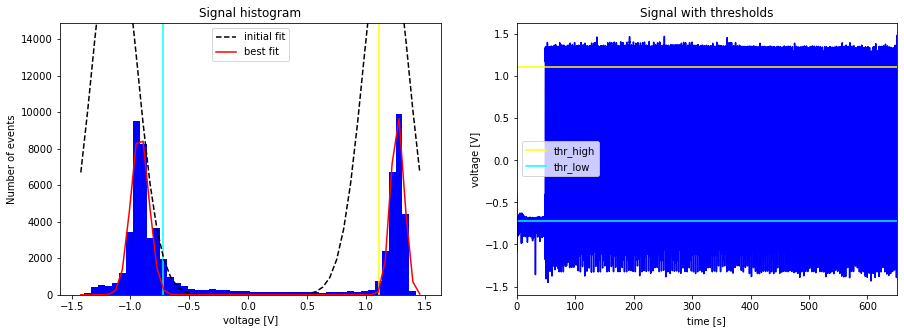

In [12]:
thr_low_1, thr_high_1 = ddt.thr_searcher(sig1_high, 50, high_sigmas=3, low_sigmas=3, Xdata=t,
                                         color='blue', xlabel='time [s]', ylabel='voltage [V]')

### Signal 2

In [ ]:
thr_low_2, thr_high_2 = thr_searcher(sig2_high, 50, 'green')

### Automatic

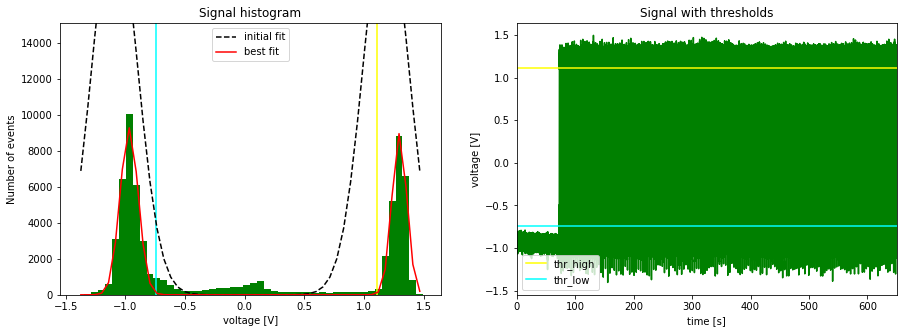

In [13]:
thr_low_2, thr_high_2 = ddt.thr_searcher(sig2_high, 50, low_sigmas=3, high_sigmas=3, Xdata=t,
                                         color='green', xlabel='time [s]', ylabel='voltage [V]')

## Drops detection

### Signal 1

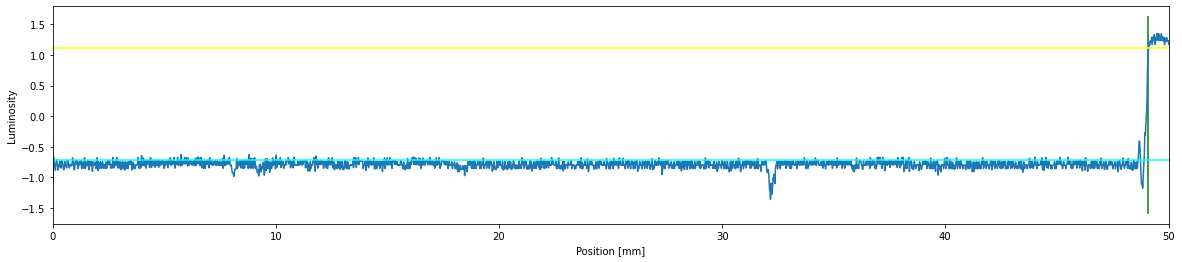

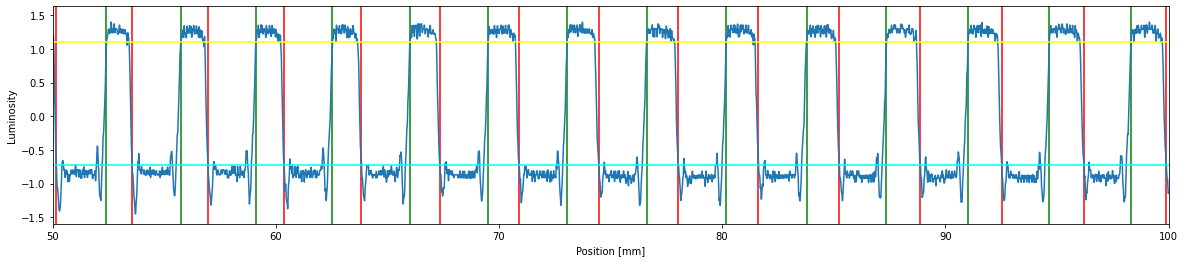

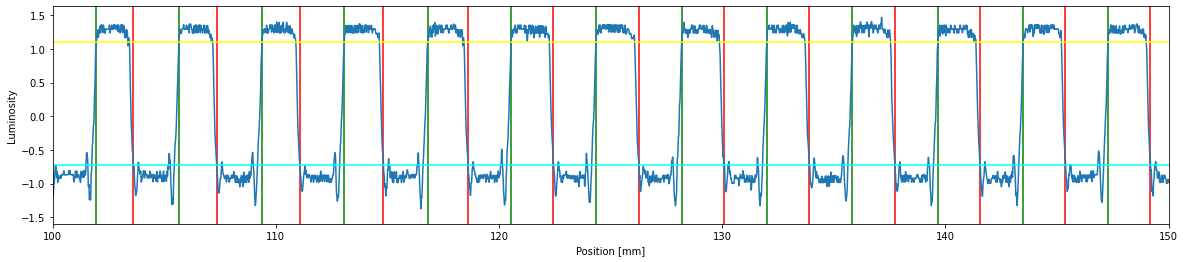

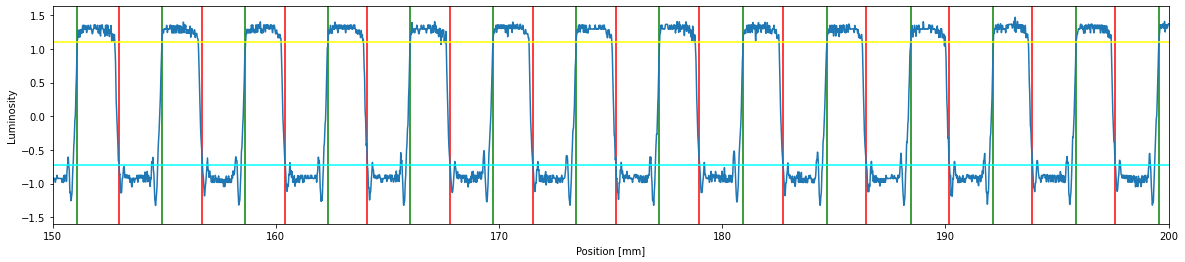

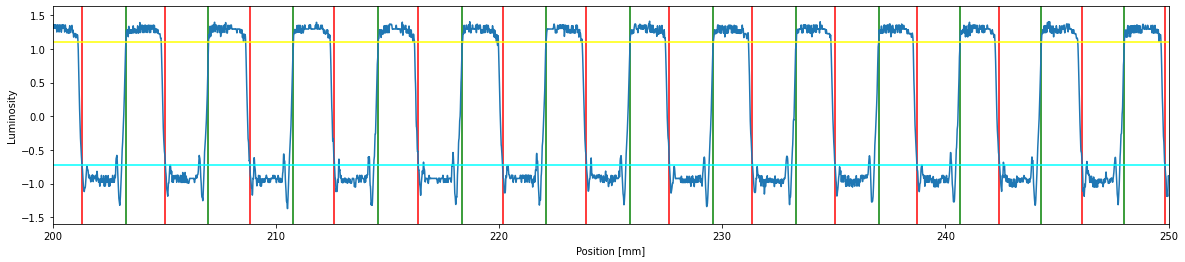

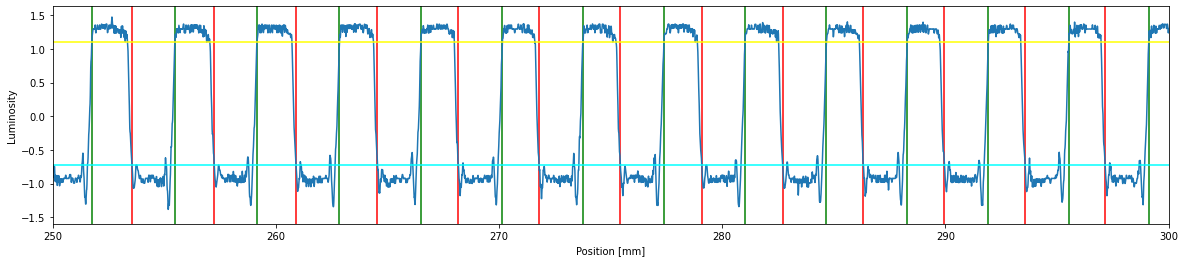

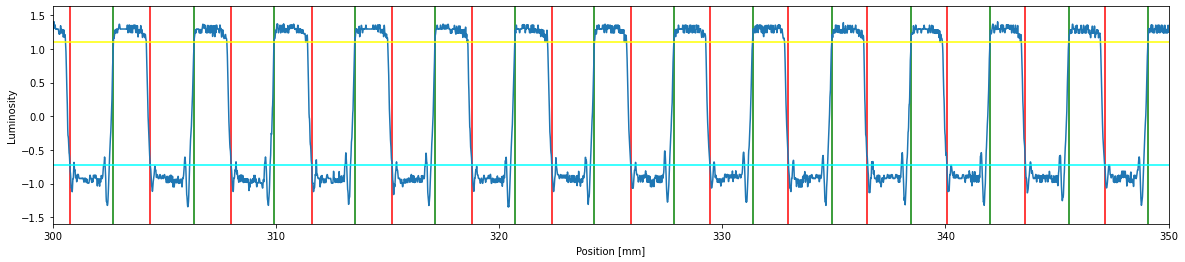

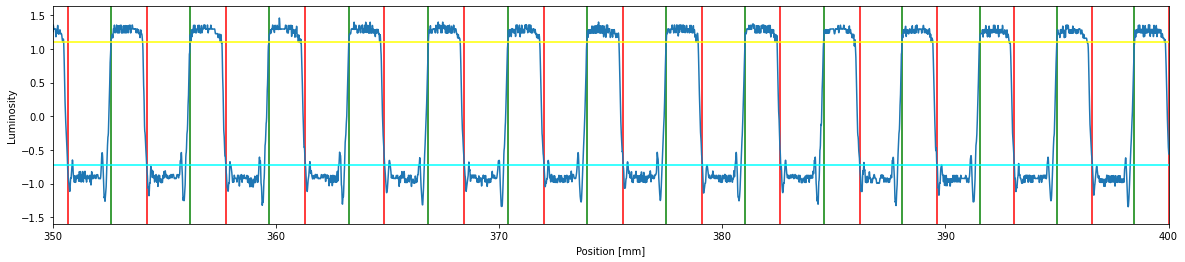

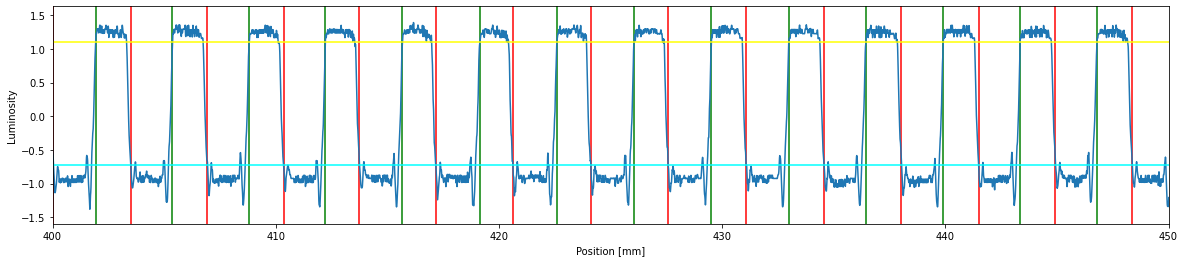

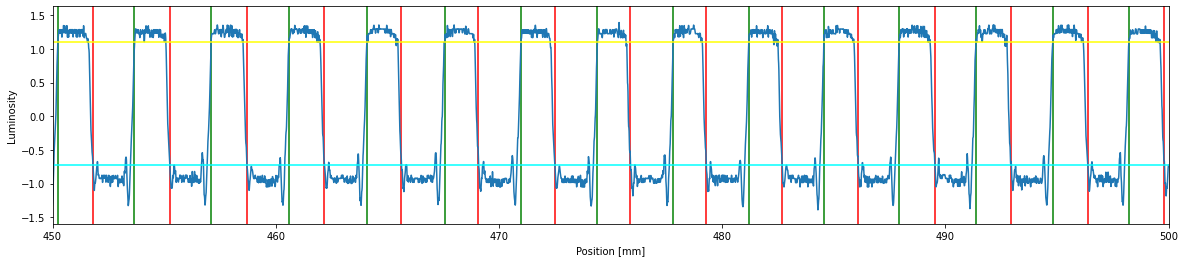

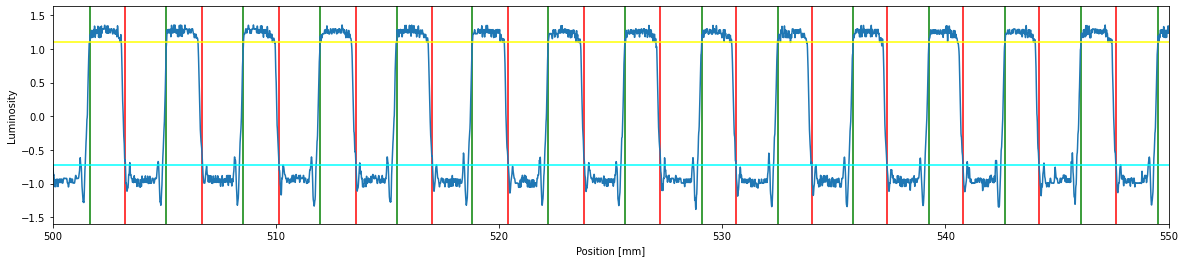

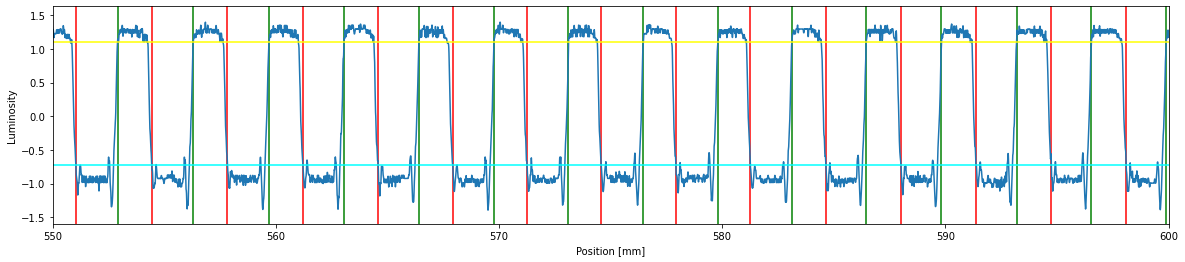

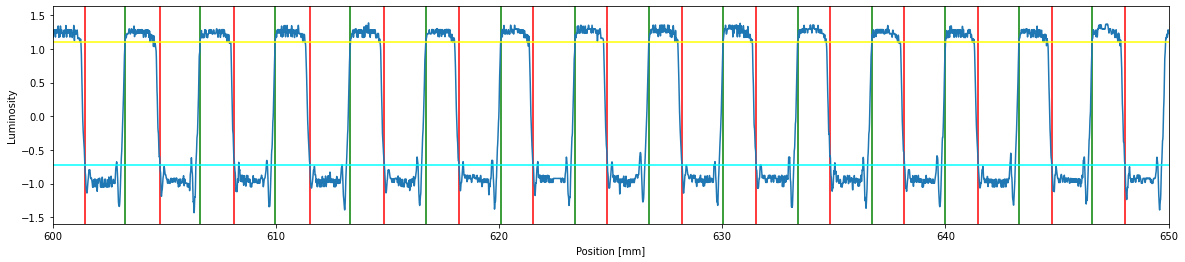

In [14]:
xrange       = 50         # single plot x range [s]
drop_start_1, drop_end_1 = ddt.drop_det(t, sig1_high, thr_low_1, thr_high_1,
                                        xrange=xrange, plot_switch=True)
global drop_start_1
global drop_end_1

### Signal 2

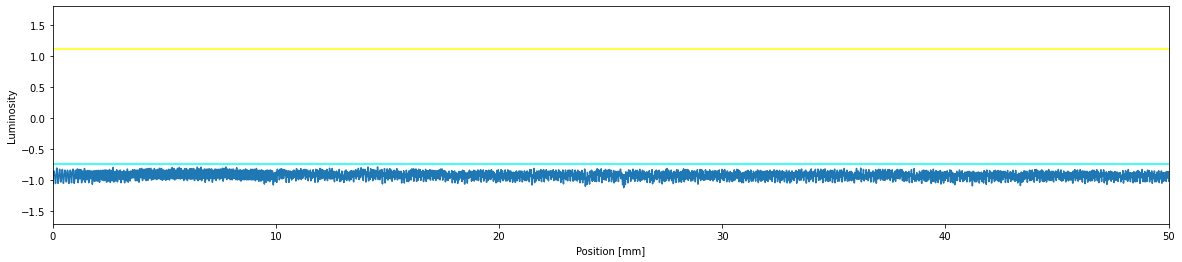

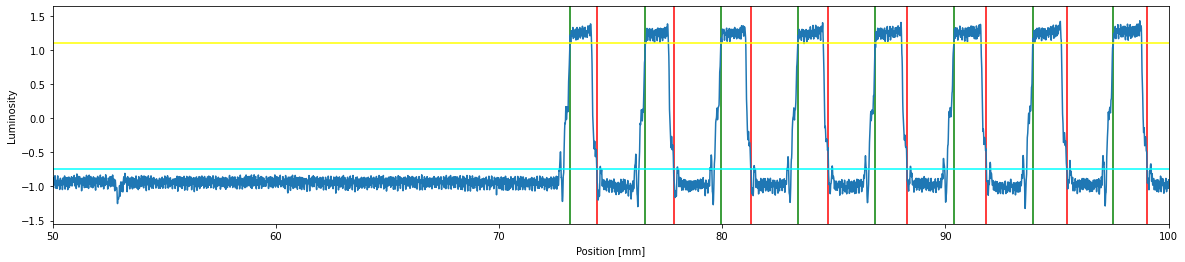

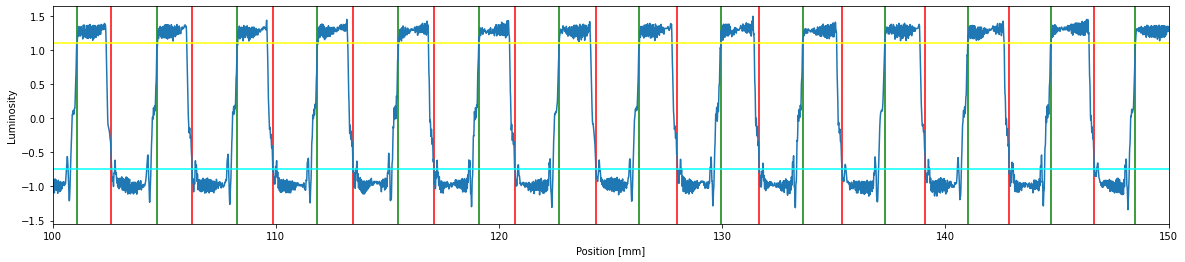

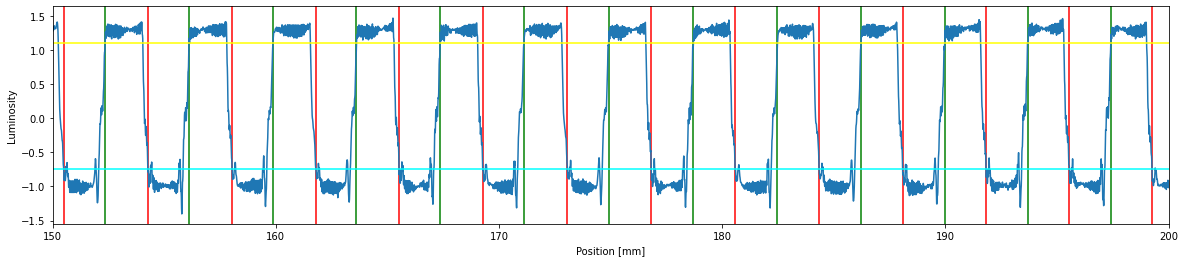

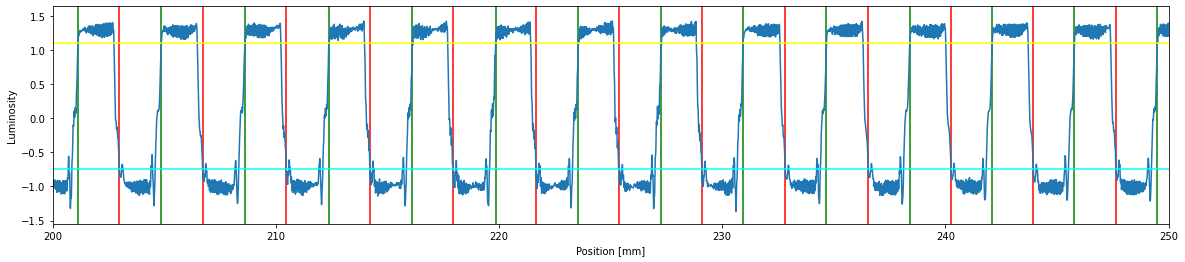

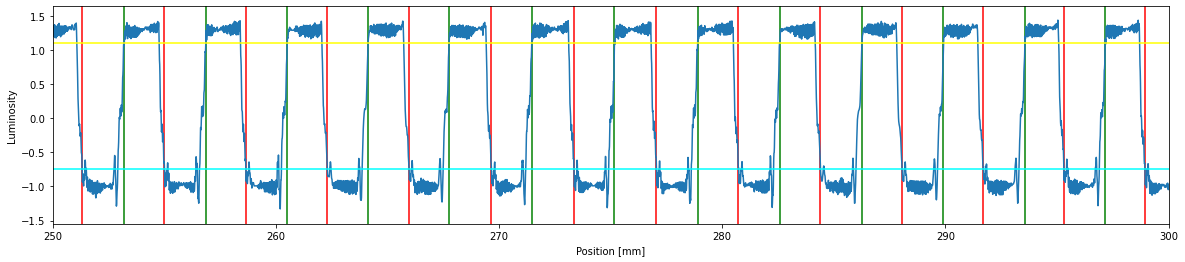

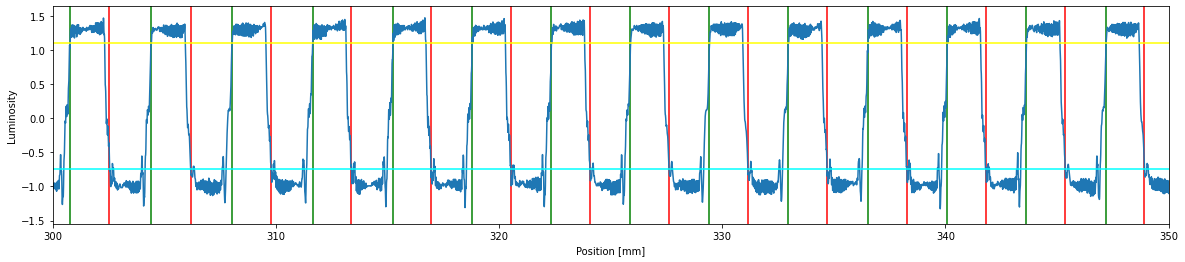

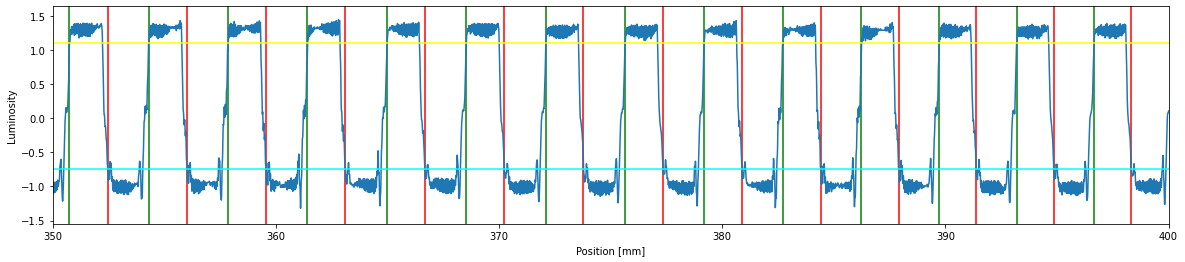

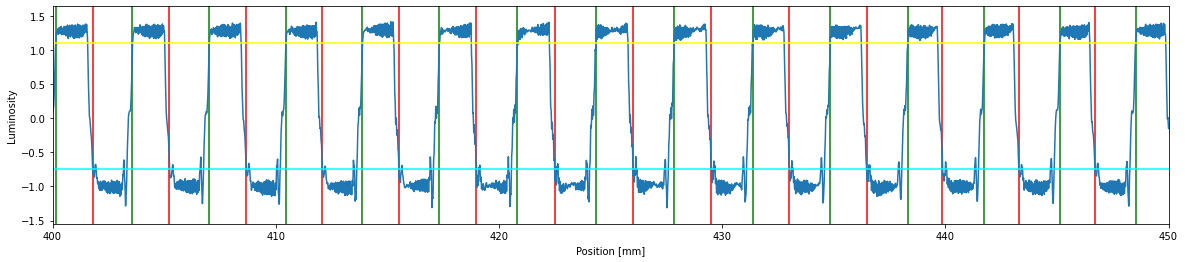

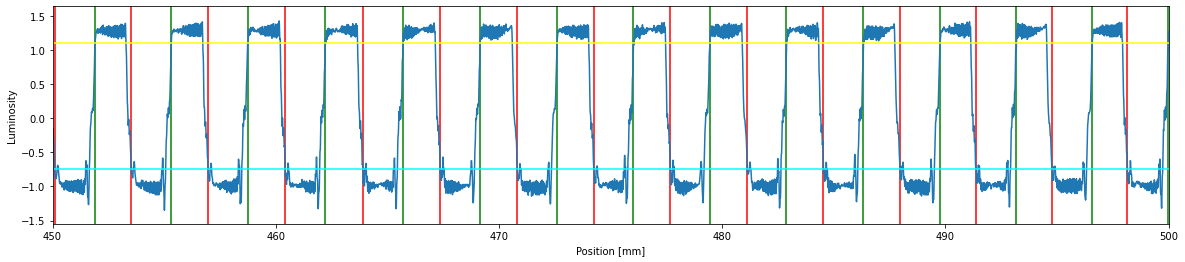

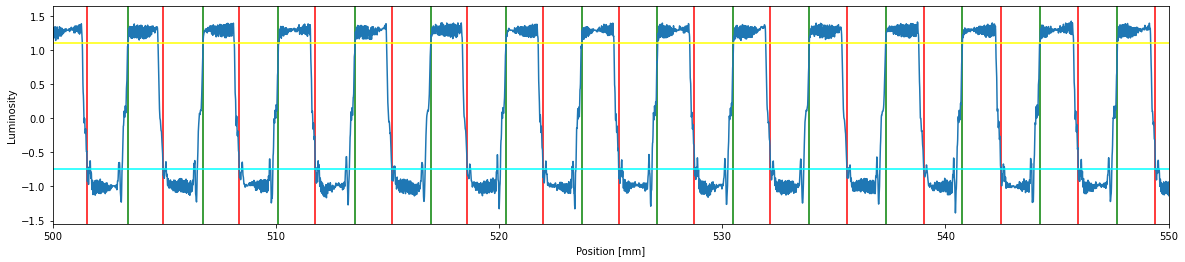

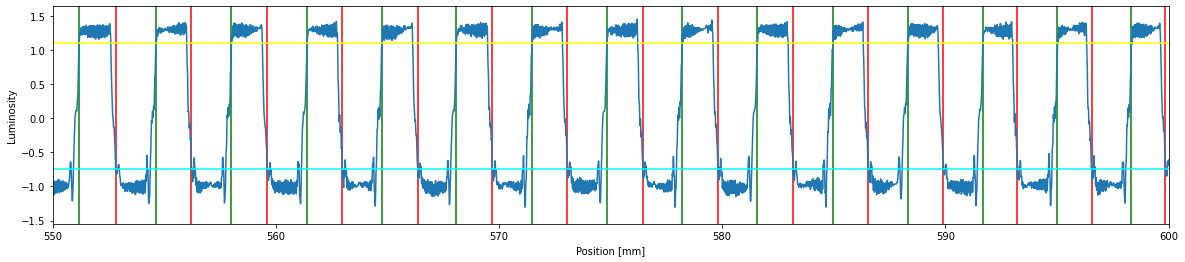

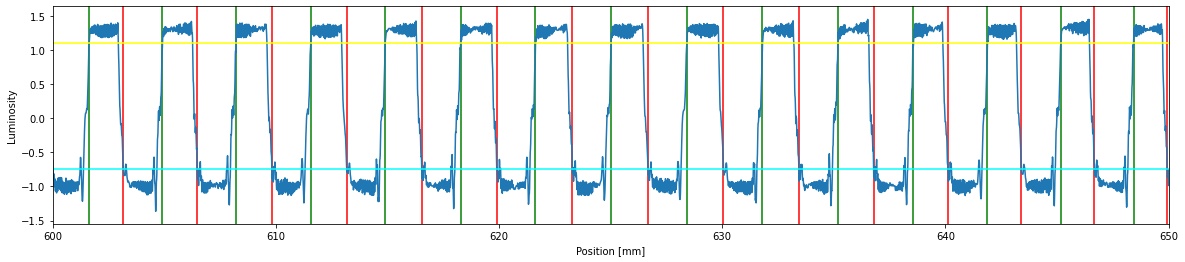

In [15]:
xrange       = 50            # single plot x range [s]
drop_start_2, drop_end_2 = ddt.drop_det(t, sig2_high, thr_low_2, thr_high_2,
                                        xrange=xrange, plot_switch=True)
global drop_start_2
global drop_end_2

In [16]:
# spannometric estimation of the time interval between the drops, knowing the pumps fluxes and capillary size

#********************************************************
radius  = 0.3  # capillary radius [mm]
sep     = 50   # spearation between the two sensors [mm]
flux_ol = 5   # oil flux   [uL/min] = [mm3/min]
flux_aq = 5    # water flux [uL/min] = [mm3/min]
#********************************************************

A  = np.pi*0.25*radius**2       # capillary area [mm2]
v  = (flux_ol + flux_aq)/A/60   # drops speed [mm/s]
dt = sep/v                      # time interval between two following drops [s]

print('v  = ', v,'\t[mm/s] \ndt = ', dt, '\t[s]')

v  =  2.3578510087688196 	[mm/s] 
dt =  21.205750411731106 	[s]


## Delay and everything that goes with it

In [43]:
def delay(delta_delay, start_time, stop_time):    
    #this function calculates delay between sig1 and sig2 by spectra smoothing (delay_gauss) 
    #and by simple spectra subtraction (delay_spectra)
    
    # Gaussian formula

    q = np.sqrt(2*np.pi)
    def gaus(x, mu, sigma):
        return np.exp(-(x - mu)**2/(2*sigma**2))/(sigma*q)

    # Gaussian smoothing functions 

    # Signal 1
    @np.vectorize
    def sig1_smooth(t, sigma, delta):
        s = 0.
        for t_s in drop_end_1:
            if (t - t_s)**2 < (delta*sigma)**2:
                s += gaus(t,t_s,sigma)
            if t_s - t > (delta+1)*sigma:
                break
        return s
    
    # Signal 2
    @np.vectorize
    def sig2_smooth(t, sigma, delta):
        s = 0.
        for t_s in drop_end_2:
            if (t - t_s)**2 < (delta*sigma)**2:
                s += gaus(t,t_s,sigma)
            if t_s - t > (delta+1)*sigma:
                break
        return s

    #*********************************************************************************************
    # Signal gaussian smoothing
    sigma       = 0.01   # stdev
    delta       = 2      # range = delta*stdev
    # Delay
    #delta_delay = 10      # range of evaluated delays = [dt - delta_delay ; dt + delta_delay] [s]
    step_delay  = 0.02   # step of evaluated delays [s]
    # Time
    # start_time  = 25     # scanning signal starting time [s]
    # stop_time   = 50    # scanning signal stopping time [s]
    step_time   = 0.005  # scanning signal step time [s]
    #*********************************************************************************************

    start_delay = dt - delta_delay                                # initial evaluated delay [s]
    stop_delay  = dt + delta_delay                                # final evaluated delay [s]
    time_delays = np.arange(start_delay, stop_delay, step_delay)  # vector of evaluated delays [s]
    ts          = np.arange(start_time,  stop_time,  step_time)   # vector of scanned times [s]
    msqs        = []                                              # stdev between sig.1 and sig.2 delayed 

    # Computing delay_gauss
    for time_delay in tqdm(time_delays):

        sig1_t = sig1_smooth(ts, sigma, delta)
        sig2_t = sig2_smooth(ts + time_delay, sigma, delta)
        msqs.append(np.mean((sig2_t - sig1_t)**2))

    msqs=np.array(msqs)
    delay_gauss=time_delays[msqs==min(msqs)]
    
    # Delay with spectra-subtraction
    delay_idxs = np.arange(4000)
    msqs1 = []

    for idx in delay_idxs:
            #sig1_cut = sig1_high[:len(sig2_high) - idx][start_time*100:stop_time*100]
            #sig2_cut = sig2_high[idx:][start_time*100:stop_time*100]
            sig1_cut = sig1_high[:len(sig2_high) - idx][0:5000]
            sig2_cut = sig2_high[idx:][0:5000]
            msqs1.append(np.mean((sig1_cut - sig2_cut)**2))
    msqs1=np.array(msqs1)
    delay_spectra=t[delay_idxs[[msqs1==min(msqs1)]]] 
   
    # Plot    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))    
    ax[0].set_title('Delay spectrum from drop ends')
    ax[0].set_xlabel("delay [s]")
    ax[0].set_ylabel("msqs")
    ax[0].plot(time_delays,msqs)
    ax[1].set_title('Delay spectrum from signal subtraction')
    ax[1].set_xlabel("Delay [s]")
    ax[1].set_ylabel("msqs")
    ax[1].set_xlim(*ax[0].get_xlim())
    ax[1].plot(t[delay_idxs],msqs1)    
    
    #define the number of initial drops to be neglected in sig2 
    neglected_drops_2 = drop_start_2[drop_start_2<delay_spectra]
    d2 = len(neglected_drops_2)    
          
    return delay_gauss, delay_spectra, d2

100%|██████████| 500/500 [00:08<00:00, 60.70it/s]
<ipython-input-43-582668d1edfa>:75: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  delay_spectra=t[delay_idxs[[msqs1==min(msqs1)]]]


<IPython.core.display.Javascript object>


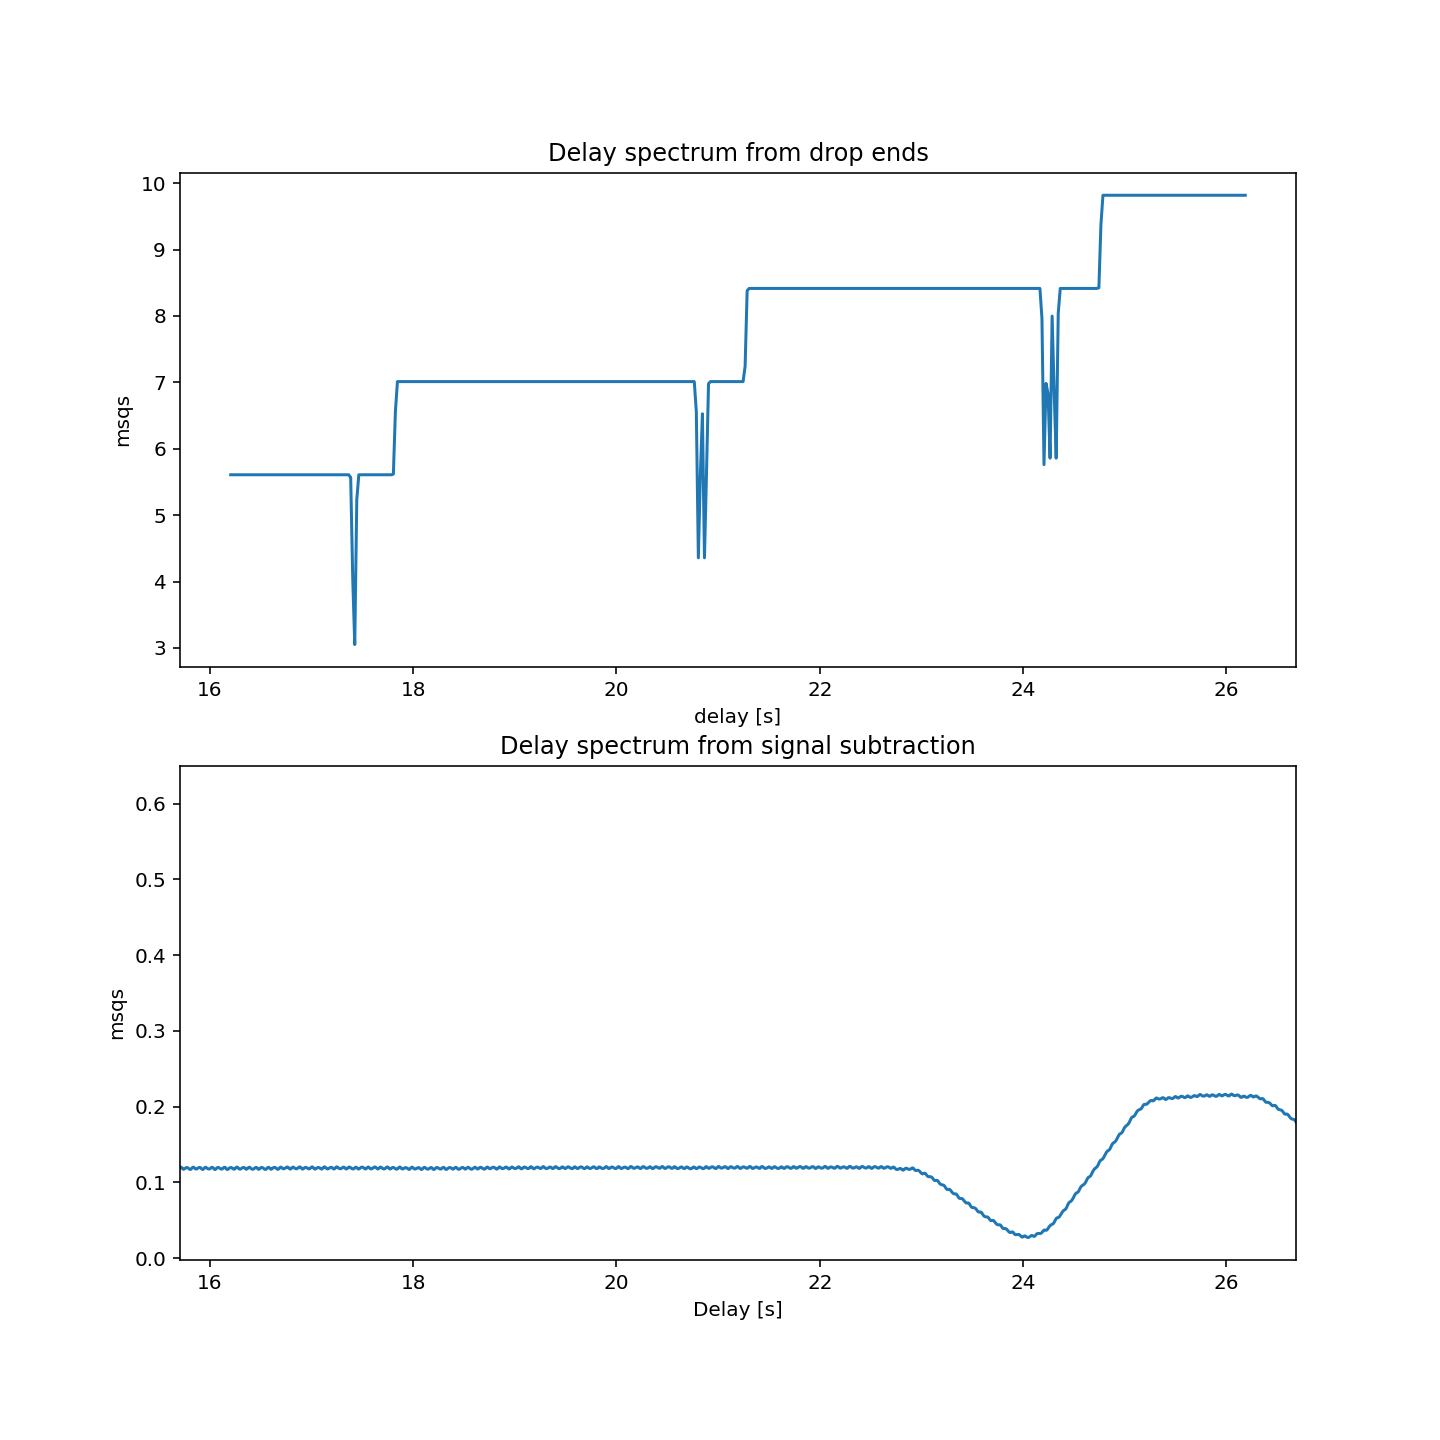

In [44]:
# Delay
delta_delay = 5      # range of evaluated delays = [dt - delta_delay ; dt + delta_delay] [s]
# Time
start_time  = 40     # scanning signal starting time [s]
stop_time   = 60    # scanning signal stopping time [s]

delay_gauss, delay_spectra, d2 = delay(delta_delay,start_time,stop_time) 

In [42]:
delay_gauss, delay_spectra, d2

(array([17.42575041]), array([20.85]), 0)

In [13]:
#decide whether to use calculated d2 or to set it by hand
#d2 = 
def adjust_drops(d1,d2):
    
    #THIS FUNCTION MODIFIES drop_start and drop_end s arrays
    global drop_start_2
    global drop_start_1
    #eliminate first sig2 drops 
    drop_start_2 = drop_start_2[d2:]
    # give drop arrays the same length
    if len(drop_start_1)>len(drop_start_2):        
        drop_start_1 = drop_start_1[:len(drop_start_2)]
    else: print("Ground control, there's something wrong")
    #if d1 != 0 cut both arrays
    drop_start_1 = drop_start_1[d1:]
    drop_start_2 = drop_start_2[d1:]
    
    global drop_end_2
    global drop_end_1
    #eliminate first sig2 drops 
    drop_end_2 = drop_end_2[d2:]
    # give drop arrays the same length
    if len(drop_end_1)>len(drop_end_2):        
        drop_end_1 = drop_end_1[:len(drop_end_2)]
    else: print("Ground control, there's something wrong")
    #if d1 != 0 cut both arrays
    drop_end_1 = drop_end_1[d1:]
    drop_end_2 = drop_end_2[d1:]
    #define drops mid points
    drop_mid_1 = 0.5*(drop_start_1+drop_end_1)
    drop_mid_2 = 0.5*(drop_start_2+drop_end_2)
    
    return drop_mid_1, drop_mid_2


In [14]:
#THIS FUNCTION MODIFIES drop_start and drop_end s arrays
#to be executed only once

d1=0          #d1>0 to discard some initial drops that are present in both signals

drop_mid_1, drop_mid_2 = adjust_drops(d1,d2)

# PLOTTING

In [15]:
#define variables for plotting
distances = np.zeros((len(drop_start_1)-1,3))
distances[:,0] = np.arange((len(drop_start_1)-1))
distances[:,1] = drop_start_1[1:] - drop_end_1[:-1]
distances[:,2] = drop_start_2[1:] - drop_end_2[:-1]

sizes = np.zeros((len(drop_start_1),3))
sizes[:,0] = np.arange(len(drop_start_1))
sizes[:,1] = drop_end_1 - drop_start_1
sizes[:,2] = drop_end_2 - drop_start_2

dt_mid = drop_mid_2 - drop_mid_1
v_mid = 50/dt_mid

## Temporal distance between drops in the same signal 

In [16]:
def time_dist(bins, distances):

    fig = plt.figure(figsize=(10,7))
    gs = GridSpec(4,5)

    ax_joint = fig.add_subplot(gs[1:4,0:3])
    ax_marg_y_1 = fig.add_subplot(gs[1:4,3])
    ax_marg_y_2 = fig.add_subplot(gs[1:4,4])

    ax_joint.plot(distances[:,0],distances[:,1], label='sig1')
    ax_joint.plot(distances[:,0],distances[:,2], color='green', label='sig2')
    h1=ax_marg_y_1.hist(distances[:,1],orientation="horizontal",bins=bins)
    h2=ax_marg_y_2.hist(distances[:,2],orientation="horizontal", color='green',bins=bins)

    # Turn off tick labels on marginals
    plt.setp(ax_marg_y_1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y_2.get_yticklabels(), visible=False)

    # Set labels on joint
    ax_joint.set_xlabel('drop id')
    ax_joint.set_ylabel('distances [s]')

    #Legend
    ax_joint.legend(loc='best')
    plt.title('Temporal distance between drops in the same signal, as a function of drop id number',loc='right', pad=15)

    #histogram fit
    b1 = h1[1]
    f1 = h1[0]
    x1 = 0.5 *(b1[:-1] + b1[1:])
    mod1 = GaussianModel(prefix='g1_')
    pars1 = mod1.guess(f1, x=x1)
    out1 = mod1.fit(f1, pars1, x=x1)
    ax_marg_y_1.plot(out1.best_fit, x1, 'r-', label='best fit')
    #ax_marg_y.legend(loc='best')

    b2 = h2[1]
    f2 = h2[0]
    x2 = 0.5 *(b2[:-1] + b2[1:])
    mod2 = GaussianModel(prefix='g2_')
    pars2 = mod2.guess(f2, x=x2)
    out2 = mod2.fit(f2, pars2, x=x2)
    ax_marg_y_2.plot(out2.best_fit, x2, 'r-', label='best fit')
    #ax_marg_y.legend(loc='best')
    
    fig.tight_layout()
    plt.show()

    dist1 = out1.best_values.get('g1_center')
    sigma_dist1 = out1.best_values.get('g1_sigma')

    dist2 = out2.best_values.get('g2_center')
    sigma_dist2 = out2.best_values.get('g2_sigma')

    return fig, dist1, sigma_dist1, dist2, sigma_dist2

<ipython-input-16-ca71c323ed06>:46: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


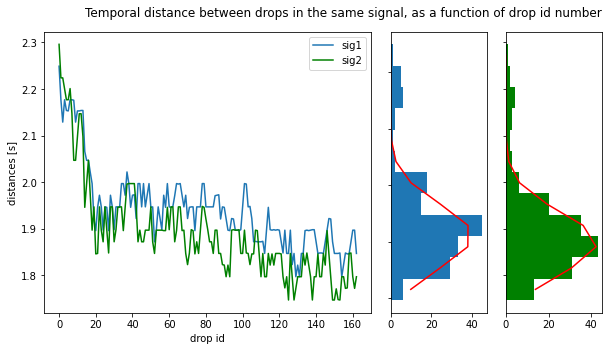

In [17]:
subname = ''

#set histogram bins
bins=12
fig, dist1, sigma_dist1, dist2, sigma_dist2 = time_dist(bins, distances)

# fig.savefig(f'Report/Plots/{name}_{subname}.pgf')
# fig.savefig(f'Report/Plots/{name}_{subname}.png')

## Temporal size 

In [18]:
def time_size(bins, sizes):

    fig = plt.figure(figsize=(10,7))
    gs = GridSpec(4,5)

    ax_joint = fig.add_subplot(gs[1:4,0:3])
    ax_marg_y_1 = fig.add_subplot(gs[1:4,3])
    ax_marg_y_2 = fig.add_subplot(gs[1:4,4])

    ax_joint.plot(sizes[:,0],sizes[:,1], label='sig1')
    ax_joint.plot(sizes[:,0],sizes[:,2], color='green', label='sig2')
    h1=ax_marg_y_1.hist(sizes[:,1],orientation="horizontal",bins=bins)
    h2=ax_marg_y_2.hist(sizes[:,2],orientation="horizontal", color='green',bins=bins)

    # Turn off tick labels on marginals
    plt.setp(ax_marg_y_1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y_2.get_yticklabels(), visible=False)

    # Set labels on joint
    ax_joint.set_xlabel('drop id')
    ax_joint.set_ylabel('distances [s]')

    ax_joint.legend(loc='best')
    plt.title('Temporal size of drops in each signal, as a function of drop id number',loc='right', pad=15)

    #histogram fit
    b1 = h1[1]
    f1 = h1[0]
    x1 = 0.5 *(b1[:-1] + b1[1:])
    mod1 = GaussianModel(prefix='g1_')
    pars1 = mod1.guess(f1, x=x1)
    out1 = mod1.fit(f1, pars1, x=x1)
    ax_marg_y_1.plot(out1.best_fit, x1, 'r-', label='best fit')
    #ax_marg_y.legend(loc='best')

    b2 = h2[1]
    f2 = h2[0]
    x2 = 0.5 *(b2[:-1] + b2[1:])
    mod2 = GaussianModel(prefix='g2_')
    pars2 = mod2.guess(f2, x=x2)
    out2 = mod2.fit(f2, pars2, x=x2)
    ax_marg_y_2.plot(out2.best_fit, x2, 'r-', label='best fit')
    #ax_marg_y.legend(loc='best')
    
    fig.tight_layout()
    plt.show()

    t_size1 = out1.best_values.get('g1_center')
    sigma_t_size1 = out1.best_values.get('g1_sigma')

    t_size2 = out2.best_values.get('g2_center')
    sigma_t_size2 = out2.best_values.get('g2_sigma')
    
    return fig, t_size1, sigma_t_size1, t_size2, sigma_t_size2 


<ipython-input-18-a32e937e9fbb>:45: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


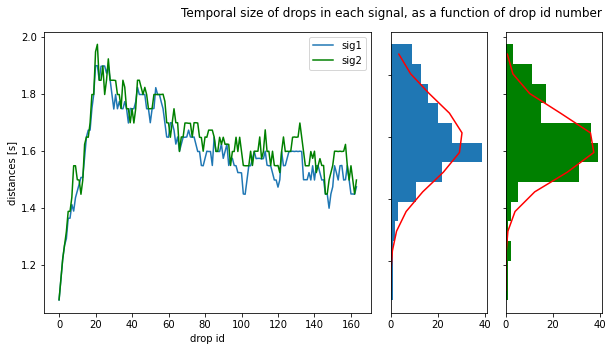

In [19]:
subname = ''

#set histogram bins
bins=13
fig, t_size1, sigma_t_size1, t_size2, sigma_t_size2 = time_size(bins, sizes)

# fig.savefig(f'Report/Plots/{name}_{subname}.pgf')
# fig.savefig(f'Report/Plots/{name}_{subname}.png')

## Time separation between detectors and drop velocity

In [20]:
def dt_vel(bins,dt_mid,v_mid):
    
    fig = plt.figure(figsize=(10,7.5))

    gs = GridSpec(8,4)
    #first plot
    ax_joint = fig.add_subplot(gs[1:4,0:3])
    ax_marg_y = fig.add_subplot(gs[1:4,3])

    ax_joint.plot(dt_mid, label='time interval')
    ax_marg_y.hist(dt_mid,orientation="horizontal", bins=bins)

    ax_joint.set_xlabel('drop id')
    ax_joint.set_ylabel('detectors time interval [s]')

    plt.title('Temporal delay of drops in the detectors and drop velocity',loc='right', pad=15)

    plt.setp(ax_marg_y.get_yticklabels(), visible=False)

    #second plot
    ax1_joint = fig.add_subplot(gs[5:8,0:3])
    ax1_marg_y = fig.add_subplot(gs[5:8,3])

    ax1_joint.plot(drop_mid_1,v_mid, label='velocity')
    ax1_marg_y.hist(v_mid,orientation="horizontal", bins=bins)

    ax1_joint.set_xlabel('time (drop equidistant from detectors) [s]')
    ax1_joint.set_ylabel('drops velocity [mm/s]')

    plt.setp(ax1_marg_y.get_yticklabels(), visible=False)


    # Set labels on marginals
    #ax_marg_x.set_ylabel('Marginal y label')
    #Legend
    #ax_joint.legend(loc='best')
    
    fig.tight_layout()
    
    plt.show()

    return fig

<ipython-input-20-7f7e557b3874>:38: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


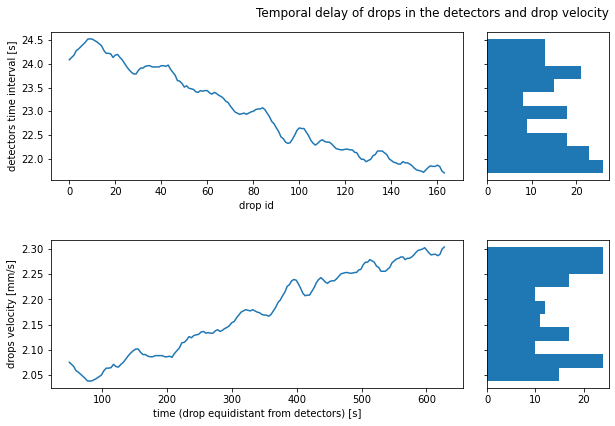

In [21]:
subname = ''

bins = 10
fig = dt_vel(bins, dt_mid, v_mid)

# fig.savefig(f'Report/Plots/{name}_{subname}.pgf')
# fig.savefig(f'Report/Plots/{name}_{subname}.png')

## Spatial size

In [22]:
def space_size(bins, sizes, vel_mid):
    
    fig = plt.figure(figsize=(10,7))
    gs = GridSpec(4,5)

    ax_joint = fig.add_subplot(gs[1:4,0:3])
    ax_marg_y_1 = fig.add_subplot(gs[1:4,3])
    ax_marg_y_2 = fig.add_subplot(gs[1:4,4])

    ax_joint.plot(sizes[:,1]*vel_mid, label='sig1')
    ax_joint.plot(sizes[:,2]*vel_mid, color='green', label='sig2')
    h1=ax_marg_y_1.hist(sizes[:,1]*vel_mid,orientation="horizontal",bins=bins)
    h2=ax_marg_y_2.hist(sizes[:,2]*vel_mid,orientation="horizontal", color='green',bins=bins)

    # Turn off tick labels on marginals
    plt.setp(ax_marg_y_1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y_2.get_yticklabels(), visible=False)

    # Set labels on joint
    ax_joint.set_xlabel('drop id')
    ax_joint.set_ylabel('size [mm]')

    ax_joint.legend(loc='best')
    plt.title('Spatial size of drops in each signal, as a function of drop id number',loc='right', pad=15)

    #histogram fit
    b1 = h1[1]
    f1 = h1[0]
    x1 = 0.5 *(b1[:-1] + b1[1:])
    mod1 = GaussianModel(prefix='g1_')
    pars1 = mod1.guess(f1, x=x1)
    out1 = mod1.fit(f1, pars1, x=x1)
    ax_marg_y_1.plot(out1.best_fit, x1, 'r-', label='best fit')
    #ax_marg_y.legend(loc='best')

    b2 = h2[1]
    f2 = h2[0]
    x2 = 0.5 *(b2[:-1] + b2[1:])
    mod2 = GaussianModel(prefix='g2_')
    pars2 = mod2.guess(f2, x=x2)
    out2 = mod2.fit(f2, pars2, x=x2)
    ax_marg_y_2.plot(out2.best_fit, x2, 'r-', label='best fit')
    #ax_marg_y.legend(loc='best')
    
    #fig.tight_layout()
    
    plt.show()
    
    #parameters from fit
    size1 = out1.best_values.get('g1_center')
    sigma_size1 = out1.best_values.get('g1_sigma')

    size2 = out2.best_values.get('g2_center')
    sigma_size2 = out2.best_values.get('g2_sigma')
    
    return fig, size1, sigma_size1, size2, sigma_size2

<ipython-input-22-c88bdd57b33c>:45: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()
<ipython-input-22-c88bdd57b33c>:47: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


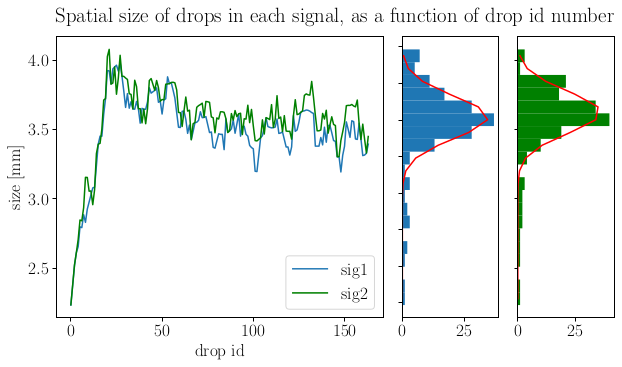

In [25]:
subname = 'spatial_size_test'

bins =20
fig, size1, sigma_size1, size2, sigma_size2  = space_size(bins, sizes, v_mid)

fig.savefig(f'Report/Plots/{name}_{subname}.pgf')
fig.savefig(f'Report/Plots/{name}_{subname}.png')

## Save fit parameters to file

In [ ]:
fit_filename ='fit-'+filename[:-4]+'.txt'
with open(fit_filename, mode='w', newline ='') as file:
    writer = csv.writer(file, delimiter='	', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    s = ['file containing center1, sigma1, center2, sigma2 from fit']
    writer.writerow(s)
    a = ['spatial size (mm)',size1, sigma_size1, size2, sigma_size2]
    writer.writerow(a)
    b = ['temporal size (s)',t_size1, sigma_t_size1, t_size2, sigma_t_size2]
    writer.writerow(b)
    c = ['temporal distance (mm)',dist1, sigma_dist1, dist2, sigma_dist2]
    writer.writerow(c)
    

## Run the following to enable the latex machine, then run the plotting cells to save the plots

In [23]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
#     'font.size' : 14.4,
    'font.size' : 17.28,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [ ]:
name